# **CP8339: Assignment 1**

In this assignment, I used the Amazon review dataset 2023 (https://amazon-reviews2023.github.io/). I downloaded the All_Beauty file with rating only. In this notebook, I will do the following to the dataset:


<ol start="1">
  <li>Preprocessing data</li>
  <li>Run baseline recommendation models:</li>
    <ul>
      <li>userKNN: User-based collaborative filtering</li>
        <ul>
          <li>Basic KNN</li>
          <li>KNN with Means</li>
        </ul>
      <li>itemKNN: Basic Item-based collaborative filtering</li>
      <li>SVD: Singular Value Decomposition</li>
    </ul>
    <li>Run an advanced recommendation models, i.e. deep learning model:</li>
    <ul>
      <li>Neural Collaboration Filtering</li>
    </ul>
  <li>Report the results using two types of evaluation metrics:</li>
    <ul>
    <li>Error metrics:</li>
    <ul>
      <li>RMSE</li>
      <li>MAE</li>
    </ul>
    <li>Accuracy metrics:</li>
      <ul>
      <li>Precision</li>
      <li>Recall</li>
      </ul>
    </ul>
</ol>

<br>

Feature | Device Information
-------------------|------------------
OS|	Windows 11 Home
Processor|	Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz (2.40 GHz)
Installed RAM|	16.0 GB (15.8 GB usable)
Graphics Card| 6 GB NVIDIA GeForce GTX 1660 Ti
System type|	64-bit operating system, x64-based processor
<br>
---


# **1 Exploratory Data Analysis And Pre-Processing**

I will do exploratory data analysis (EDA) and pre-processing the data simultaneously.
<br>

The following are done during EDA:
*   Univariate Non-Graphical EDA
*   Univariate Graphical EDA
*   Multivariate Non-Graphical EDA
*   Multivariate Graphical EDA

The following are done during preprocessing:
*   Data Cleaning
*   Data Transformation
*   Data Reduction
*   Data Splitting


## About Dataset and Columns
I used the All_Beauty dataset from Amazon Review 2023. I accessed the dataset using Hugging Face as my laptop was struggling to work with the entire dataset.
<br>


Columnn|Description
-------------------|------------------
**user_id**	(str)|	ID of the reviewer
**parent_asin** (str)|	Parent ID of the product*
**rating**	(float)|	Rating of the product (from 1.0 to 5.0)
**timestamp**	(int)|	Time of the review (unix time)

<br>

*Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta.

## Install And Import Libraries

In [ ]:
!pip install numpy==1.26.4
!pip install datasets==3.6.0
!pip install scikit-surprise

In [ ]:
# Import libraries

import random

import os

import datasets
from datasets import load_dataset, Dataset, DatasetDict

import numpy as np

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

import surprise
from surprise import accuracy, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_split
from surprise.model_selection import cross_validate
from surprise import KNNBasic, KNNWithMeans
from surprise import accuracy

## Load Dataset

In [ ]:
# If there is an error, explain in fully
datasets.logging.set_verbosity_error()

# Loading the 0-core dataset without splitting
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "0core_rating_only_All_Beauty", trust_remote_code=True)

# Converting dataset from DatasetDict object to pandas
dataset.set_format(type='pandas')
df = dataset['full'][:]

# Check the dataframe
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,user_id,parent_asin,rating,timestamp
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0,1588615855070
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0,1588687728923
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0,1589665266052
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0,1609322563534
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0,1643393630220


## Dataset Cleaning & Transformation



In [ ]:
# Format column names to (user_id, item_id, rating) - expected by Surprise

# Drop rows that are not useful
col = ['timestamp']
df = df.drop(col, axis=1)

# Rename parent_asin column to a more readable name
df = df.rename(columns={'parent_asin': 'item_id'})

# Change datatypes of columns
df = df.astype({'rating': float})

# Check the dataframe
df.head()

,user_id,item_id,rating
0,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B081TJ8YS3,4.0
1,AGKHLEW2SOWHNMFQIJGBECAF7INQ,B00YQ6X8EO,5.0
2,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,B097R46CSY,5.0
3,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B08BZ63GMJ,5.0
4,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,B09JS339BZ,1.0


## EDA

### Univariate Non-Graphical EDA
Analyzing just one variable at a time to find any patterns within it.

In [ ]:
# Explore data shape
print("\nSHAPE:")
print(df.shape)

# Explore data spread
print("\nDESCRIBE:")
df.describe(include = 'all')


SHAPE:
(693929, 3)

DESCRIBE:


,user_id,item_id,rating
count,693929,693929,693929.000000
unique,631986,112565,NaN
top,AG73BVBKUOH22USSFJA5ZWL7AKXA,B085BB7B1M,NaN
freq,164,1952,NaN
mean,NaN,NaN,3.960676
std,NaN,NaN,1.494040
min,NaN,NaN,1.000000
25%,NaN,NaN,3.000000
50%,NaN,NaN,5.000000
75%,NaN,NaN,5.000000


In [ ]:
# Inspect data
print("INFO:")
print(df.info())

# Check for missing values
print("\nEMPTY ROWS:")
print(df.isnull().sum())

# Check for duplicates
print("\nNUMBER OF DUPLICATED ROWS:")
print(df.duplicated().sum()) # assumption: users can only rate the item once

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693929 entries, 0 to 693928
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  693929 non-null  object 
 1   item_id  693929 non-null  object 
 2   rating   693929 non-null  float64
dtypes: float64(1), object(2)
memory usage: 15.9+ MB
None

EMPTY ROWS:
user_id    0
item_id    0
rating     0
dtype: int64

NUMBER OF DUPLICATED ROWS:
0


In [ ]:
 # Unique values
user_num = len(df.user_id.unique())
item_num = len(df.item_id.unique())
rating_num = len(df)
print("Number of unique users:",user_num)
print("Number of unique products:",item_num)
print("Number of ratings:",rating_num)

# How sparse is the matrix?
filled = 100*rating_num/(user_num*item_num)
print("Number of elements in matrix is:",user_num*item_num)
print("% of matrix filled: ",filled)

Number of unique users: 631986
Number of unique products: 112565
Number of ratings: 693929
Number of elements in matrix is: 71139504090
% of matrix filled:  0.0009754481829422041


In [ ]:
# Find users that rated less than 6 times
user_rating_counts = df['user_id'].value_counts()
users_to_remove = user_rating_counts[user_rating_counts <= 5].index

print(f"\n\nTotal Number of Ratings: {len(df)}")
print(f"Total Number of Users: {len(df.user_id.unique())}")
print(f"Number of users who gave <=5: {len(users_to_remove)}")
print(f"Number of users who gave >5 ratings: {len(user_rating_counts)-len(users_to_remove)}")

# Find items with less than 6 ratings overall
item_rating_counts = df['item_id'].value_counts()
items_to_remove = item_rating_counts[item_rating_counts <= 5].index

print(f"\n\nTotal Number of Ratings: {len(df)}")
print(f"Total Number of Items: {len(df.item_id.unique())}")
print(f"Number of items with 5 or fewer ratings: {len(items_to_remove)}")
print(f"Number of items with >5 ratings: {len(item_rating_counts)-len(items_to_remove)}")



Total Number of Ratings: 693929
Total Number of Users: 631986
Number of users who gave <=5: 631018
Number of users who gave >5 ratings: 968


Total Number of Ratings: 693929
Total Number of Items: 112565
Number of items with 5 or fewer ratings: 89959
Number of items with >5 ratings: 22606


In [ ]:
# Average rating a user gives
ratings_user = pd.DataFrame(df.groupby('user_id')['rating'].mean())
ratings_user.rename(columns={'rating': 'ratings_average'}, inplace=True)
ratings_user['ratings_count'] = pd.DataFrame(df.groupby('user_id')['rating'].count())

print("Average RatingUser Gives:")
print(ratings_user.head(10))

print("\nAverage Rating User Gives, Order by Desc Count of Ratings they gave:")
print(ratings_user.sort_values(by='ratings_count', ascending=False).head(10))

Average RatingUser Gives:
                              ratings_average  ratings_count
user_id                                                     
AE222BBOVZIF42YOOPNBXL4UUMYA              5.0              1
AE222FP7YRNFCEQ2W3ZDIGMSYTLQ              5.0              1
AE222X475JC6ONXMIKZDFGQ7IAUA              5.0              1
AE222Y4WTST6BUZ4J5Y2H6QMBITQ              4.0              1
AE2232TEZOEWQLAFEX2NA6VBGMYQ              5.0              1
AE22355IAQGYY4EPWWVYX25J7AHA              1.0              1
AE223EVQI22TZJEZG3F2PG5Y57FQ              4.0              1
AE223FOBUQAUOSGVCDRABQGKGVSQ              5.0              1
AE223N4K4ROAGJPN55UM3IYGGCOQ              5.0              1
AE223QFU63B3X4P437QAGGX5V3CQ              5.0              1

Average Rating User Gives, Order by Desc Count of Ratings they gave:
                                ratings_average  ratings_count
user_id                                                       
AG73BVBKUOH22USSFJA5ZWL7AKXA           4.53658

In [ ]:
# Average rating of items
ratings_item = pd.DataFrame(df.groupby('item_id')['rating'].mean())
ratings_item.rename(columns={'rating': 'ratings_average'}, inplace=True)
ratings_item['ratings_count'] = pd.DataFrame(df.groupby('item_id')['rating'].count())

print("Average Rating of Item:")
print(ratings_item.head(10))

print("\nAverage Rating of Item, Order by Desc Count of Ratings:")
print(ratings_item.sort_values(by='ratings_count', ascending=False).head(10))

Average Rating of Item:
            ratings_average  ratings_count
item_id                                   
0005946468         5.000000              1
0123034892         5.000000              1
0124784577         4.333333              3
0515059560         4.000000              1
0692508988         5.000000              1
069267599X         4.780488             41
0764490117         5.000000              2
0816091846         4.642857             14
0963416391         5.000000              1
0966068432         5.000000              2

Average Rating of Item, Order by Desc Count of Ratings:
            ratings_average  ratings_count
item_id                                   
B085BB7B1M         4.619877           1952
B0BM4GX6TT         4.137312           1726
B07C533XCW         4.465333           1500
B09X9BG4FC         4.494868           1364
B00R1TAN7I         4.029369           1362
B08L5KN7X4         4.012048           1328
B019GBG0IE         3.536012           1319
B01M1OFZOG      

### Univariate Graphical EDA


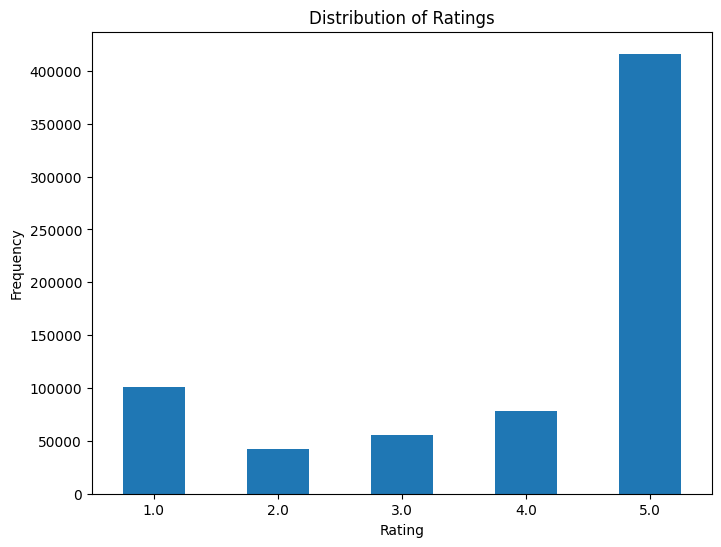

In [ ]:
# Plot the distribution of ratings

plt.figure(figsize=(8, 6))
df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

<Axes: xlabel='item_id'>

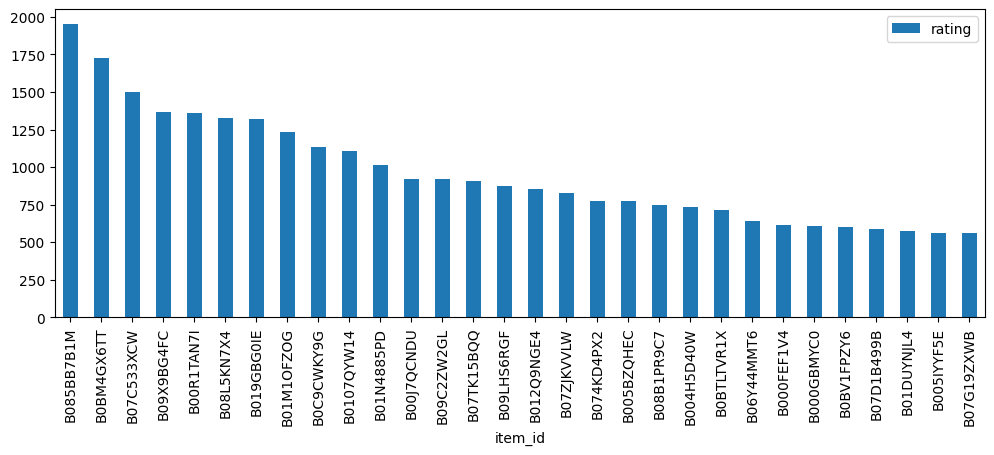

In [ ]:
# Top 30 items
popular_items = pd.DataFrame(df.groupby('item_id')['rating'].count())
most_popular = popular_items.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

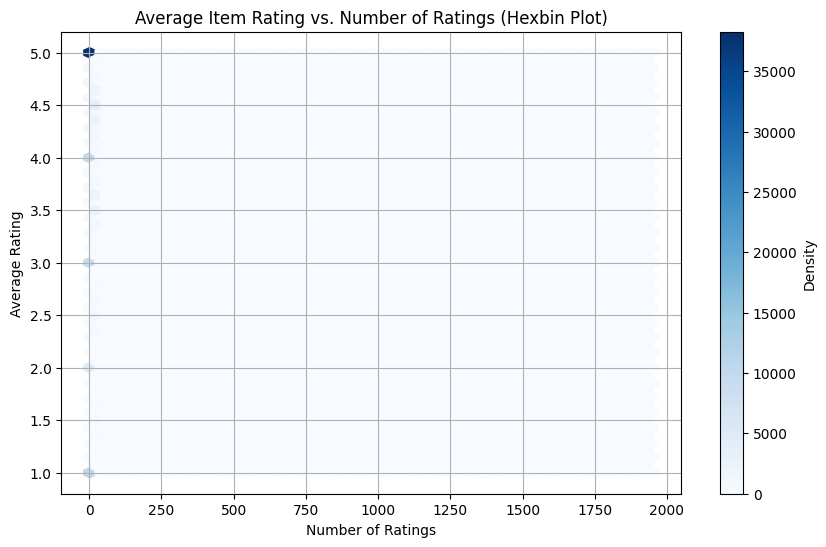

In [ ]:
# Plot average rating vs count of ratings given using a hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(x=ratings_item['ratings_count'], y=ratings_item['ratings_average'], gridsize=50, cmap='Blues')
plt.colorbar(label='Density')
plt.title('Average Item Rating vs. Number of Ratings (Hexbin Plot)')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

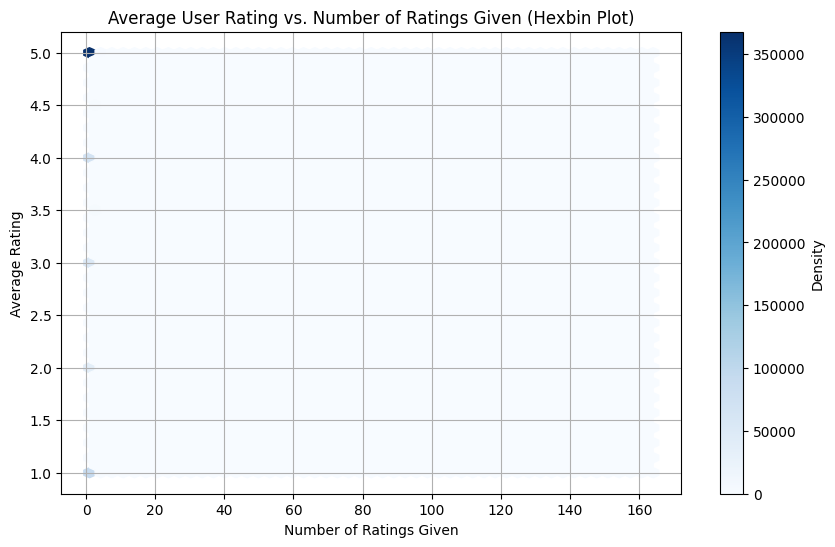

In [ ]:
# Plot average rating vs count of ratings given using a hexbin plot for users
plt.figure(figsize=(10, 6))
plt.hexbin(x=ratings_user['ratings_count'], y=ratings_user['ratings_average'], gridsize=50, cmap='Blues')
plt.colorbar(label='Density')
plt.title('Average User Rating vs. Number of Ratings Given (Hexbin Plot)')
plt.xlabel('Number of Ratings Given')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

### Multivariate Non-Graphical EDA
Cross-tabulation was not run because computationaly too large and laptop crashes. Instead, a subset of users and items are randonmly selected to create a heatmap of their interactions.

Sampled Pivot Table shape: (9, 9)


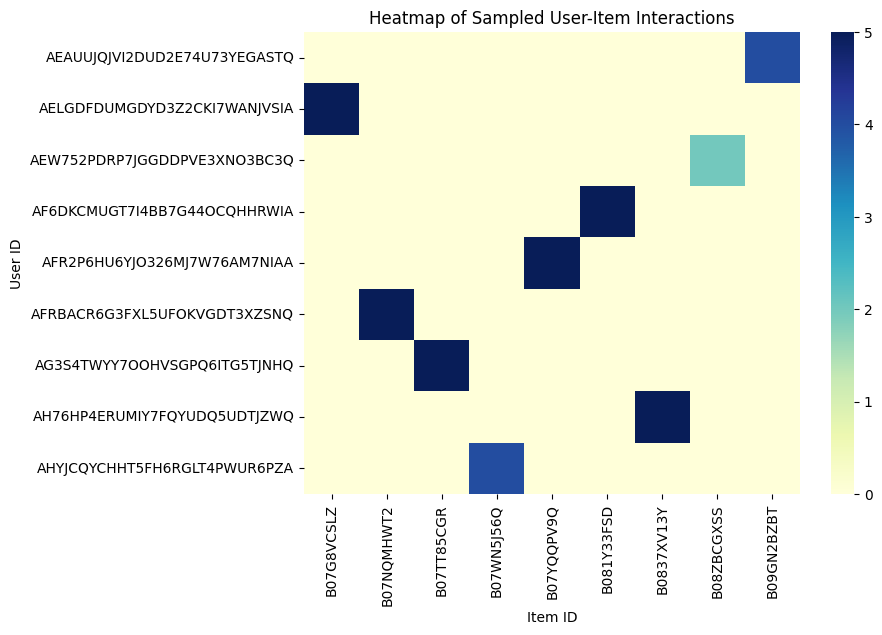

In [ ]:
# Sample a subset of users and items for the heatmap
num_users_sample = 1000
num_items_sample = 1000

# Get a list of unique users and items
unique_users = df['user_id'].unique()
unique_items = df['item_id'].unique()

# Randomly sample users and items
sampled_users = np.random.choice(unique_users, min(num_users_sample, len(unique_users)), replace=False)
sampled_items = np.random.choice(unique_items, min(num_items_sample, len(unique_items)), replace=False)

# Filter the original DataFrame to include only the sampled users and items
df_sampled = df[(df['user_id'].isin(sampled_users)) & (df['item_id'].isin(sampled_items))]

# Create a pivot table (user-item matrix) for the sampled data
# Use fill_value=0 to represent no interaction
pivot_table_sampled = df_sampled.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

print("Sampled Pivot Table shape:", pivot_table_sampled.shape)

# Create a heatmap of the sampled user-item interaction matrix
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table_sampled, cmap='YlGnBu') # Removed cbar_label
plt.title('Heatmap of Sampled User-Item Interactions')
plt.xlabel('Item ID')
plt.ylabel('User ID')
plt.show()

### Multivariate Graphical EDA


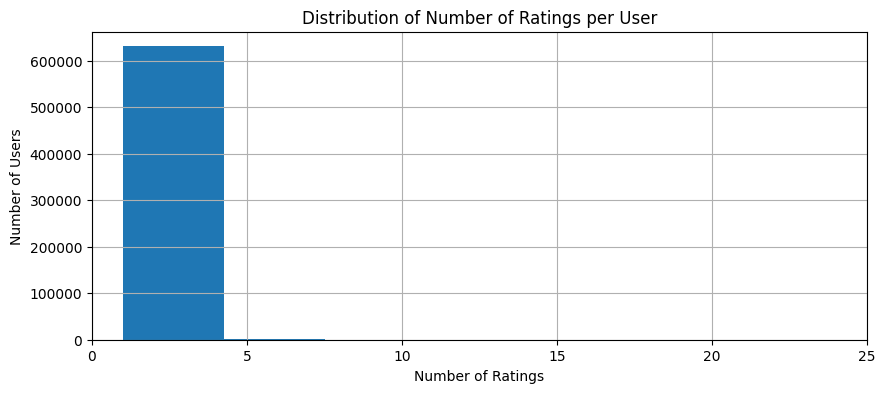

In [ ]:
# Visualize the number of users that gave the same number of ratings

plt.figure(figsize=(10, 4))
user_rating_counts.hist(bins=50)
plt.xlim(0, 25)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

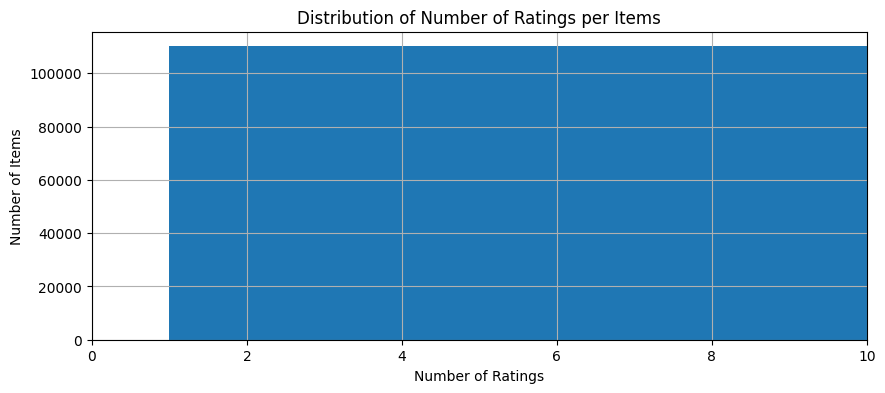

In [ ]:
# Visualize the number of items that have the same number of ratings

plt.figure(figsize=(10, 4))
item_rating_counts.hist(bins=50)
plt.xlim(0, 10)
plt.title('Distribution of Number of Ratings per Items')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Items')
plt.show()

## Observations
This dataset has the following characteristics:

*   Almost all the users have given fewer than 5 ratings. This means there is a long tail for the product ratings - almost all the products contain few ratings.
*   The ratings are skewed towards 5. Users who rate tend to do so if they love the item (5 ratings)
*   The matrix is very sparse. This is to be expected as the item universe is very lage and the user only interacts with small subset of all the existing items.
*   Seeing that the dataset contains mostly users that gave 5 or fewer ratings, I will not be removing those users. Similarily, given that the dataset contains mostly items that have 5 or fewer ratings, I will not be removing those items.





## Reducing Dataset Size

Due to hardware limitations, I have to reduce the dataset size. As the number of users and items with fewer than 5 ratings is too large, I decided to do stratified random sampling, i.e., keep the distribution of ratings the same in the newly reduced dataset created by random sampling. Later, as the error for Neural Collaborative Filtering is high, I experiment the user-stratified sampling. As random sampling can break the connection between user and the item,increasing the cold-start problem in train-test phase of the model creation, I  attempted to perform a user-stratified split to ensure each user has at least one interaction in the training set. I was unable to run it due to the hardware issues. This was a potential solution explore to reduce the high RMSE value for NCF.

In [ ]:
print("Original DataFrame shape:", df.shape)

# Reduce the dataset by stratified random sampling (e.g., 5% of the data)
sample_fraction = .05

def stratified_sample(df, stratify_col, frac, random_state=9):
    return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=random_state))

df = stratified_sample(df, 'rating', sample_fraction, random_state=9)

print("Reduced DataFrame shape:", df.shape)


Original DataFrame shape: (693929, 3)
Reduced DataFrame shape: (34697, 3)


/tmp/ipython-input-3874304717.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(stratify_col, group_keys=False).apply(lambda x: x.sample(frac=frac, random_state=random_state))


# Data Splitting

In [ ]:
# A Reader is needed to parse the file.

# The file format is user item rating
reader = Reader(rating_scale=(1, 5))

# Load the dataframe into a Surprise dataset
data = surprise.Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

# Split data into train and test sets
trainset, testset = surprise_split(data, test_size=.33, random_state=9)

# **2 KNN**

In [ ]:
from surprise import KNNBasic, KNNWithMeans
from surprise import accuracy

## **2.1 User-based: Basic KNN**
Using User-based KNN, aka Collaborative Filtering.
<br>
Default similarity is cosine. I used pearson_baseline as it is commonly used in areas like collaborative filtering, where users provide ratings on a scale.

In [ ]:
from surprise import KNNBasic, accuracy
import numpy as np

# Build the user-based KNN model
user_knn = KNNBasic(sim_options={'user_based': True, 'name': 'pearson_baseline'})

# Train the model
user_knn.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# Make predictions on the testset
predictions = user_knn.test(testset)

# Evaluate the model using RMSE, MAE
user_knn_rmse = accuracy.rmse(predictions, verbose=False)
user_knn_mae = accuracy.mae(predictions, verbose=False)

print(f"User-based KNN RMSE: {user_knn_rmse}")
print(f"\nUser-based KNN MAE: {user_knn_mae}")


User-based KNN RMSE: 1.4935027265341292

User-based KNN MAE: 1.2547800321504257


In [ ]:
from collections import defaultdict
from datasets import Dataset

from surprise import Dataset, SVD, KNNBasic, KNNWithMeans
from surprise.model_selection import KFold
from surprise import accuracy

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [ ]:
# Testing new method precision_recall_at_k()
threshold=3.5
k=5

# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(predictions, k, threshold)

# Precision and recall can then be averaged over all users
user_knn_precision = sum(prec for prec in precisions.values()) / len(precisions)
user_knn_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"Precision @ {k} (threshold = {threshold}): ")
print(user_knn_precision)
print(f"\nRecall @ {k} (threshold = {threshold}): ")
print(user_knn_recall)


threshold=3.5
k=10
# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(predictions, k, threshold)

# Precision and recall can then be averaged over all users
user_knn_precision = sum(prec for prec in precisions.values()) / len(precisions)
user_knn_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f"\nPrecision @ {k} (threshold = {threshold}): ")
print(user_knn_precision)
print(f"\nRecall @ {k} (threshold = {threshold}): ")
print(user_knn_recall)


Precision @ 5 (threshold = 3.5): 
0.7122662217929581

Recall @ 5 (threshold = 3.5): 
0.7128808499429274

Precision @ 10 (threshold = 3.5): 
0.7122662217929581

Recall @ 10 (threshold = 3.5): 
0.7128808499429274


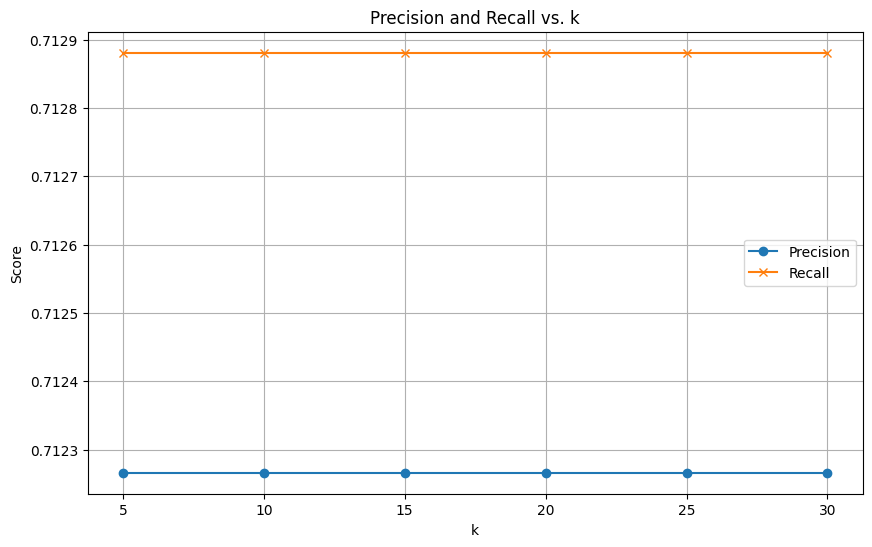

[0.7122662217929581, 0.7122662217929581, 0.7122662217929581, 0.7122662217929581, 0.7122662217929581, 0.7122662217929581]
[0.7128808499429274, 0.7128808499429274, 0.7128808499429274, 0.7128808499429274, 0.7128808499429274, 0.7128808499429274]


In [ ]:
# Calculate Precision and Recall for different k values
ks = [5, 10, 15, 20, 25, 30]
precision_scores = []
recall_scores = []


for k in ks:
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    precision_scores.append(avg_precision)
    recall_scores.append(avg_recall)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_scores, marker='o', linestyle='-', label='Precision')
plt.plot(ks, recall_scores, marker='x', linestyle='-', label='Recall')
plt.title('Precision and Recall vs. k')
plt.xlabel('k')
plt.ylabel('Score')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

print(precision_scores)
print(recall_scores)

## **2.2 User-based: KNN with Means**

In [ ]:
# Build the user-based KNN model
user_knn_means = KNNWithMeans(sim_options={'user_based': True, 'name': 'pearson_baseline'})

# Train the model
user_knn_means.fit(trainset)

# Make predictions on the testset
predictions_means = user_knn_means.test(testset)

# Evaluate the model using RMSE, MAE, Precision, Recall
user_knn_means_rmse = accuracy.rmse(predictions_means, verbose=False)
user_knn_means_mae = accuracy.mae(predictions_means, verbose=False)

print(f"User-based KNN with Means RMSE: {user_knn_means_rmse}")
print(f"User-based KNN with Means MAE: {user_knn_means_mae}")

# Calculate precision and recall at k
precisions_means, recalls_means = precision_recall_at_k(predictions_means, k=10, threshold=3.5)

# Precision and recall can then be averaged over all users
user_knn_means_precision = sum(prec for prec in precisions_means.values()) / len(precisions_means)
user_knn_means_recall = sum(rec for rec in recalls_means.values()) / len(recalls_means)


print("Precision @ 10 (threshold = 3.5): ")
print(user_knn_means_precision)
print("\nRecall @ 10 (threshold = 3.5): ")
print(user_knn_means_recall)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
User-based KNN with Means RMSE: 1.4954458004581683
User-based KNN with Means MAE: 1.2543439459330044
Precision @ 10 (threshold = 3.5): 
0.7116515936429888

Recall @ 10 (threshold = 3.5): 
0.7121345157608219


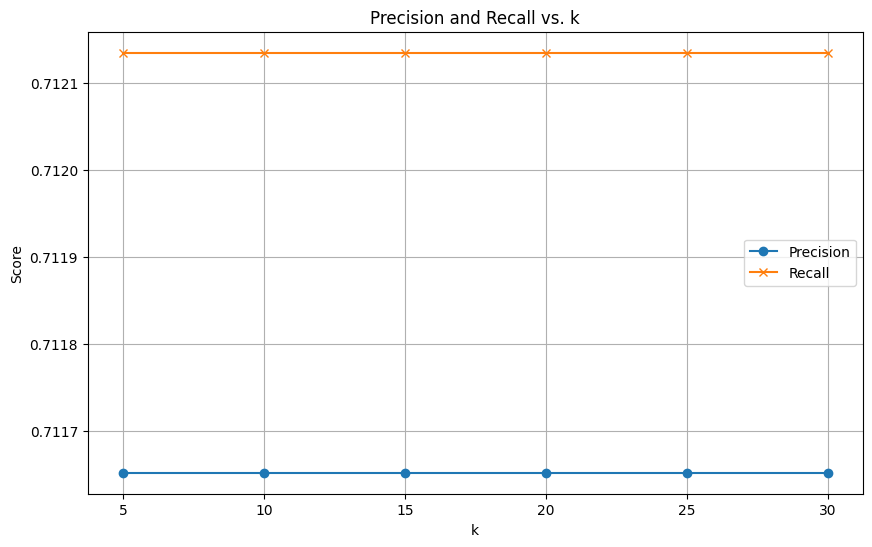

[0.7116515936429888, 0.7116515936429888, 0.7116515936429888, 0.7116515936429888, 0.7116515936429888, 0.7116515936429888]
[0.7121345157608219, 0.7121345157608219, 0.7121345157608219, 0.7121345157608219, 0.7121345157608219, 0.7121345157608219]


In [ ]:
# Calculate Precision and Recall for different k values
ks = [5, 10, 15, 20, 25, 30]
precision_scores_means = []
recall_scores_means = []


for k in ks:
    precisions_means, recalls_means = precision_recall_at_k(predictions_means, k=k, threshold=3.5)
    avg_precision_means = sum(prec for prec in precisions_means.values()) / len(precisions_means)
    avg_recall_means = sum(rec for rec in recalls_means.values()) / len(recalls_means)
    precision_scores_means.append(avg_precision_means)
    recall_scores_means.append(avg_recall_means)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_scores_means, marker='o', linestyle='-', label='Precision')
plt.plot(ks, recall_scores_means, marker='x', linestyle='-', label='Recall')
plt.title('Precision and Recall vs. k')
plt.xlabel('k')
plt.ylabel('Score')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

print(precision_scores_means)
print(recall_scores_means)

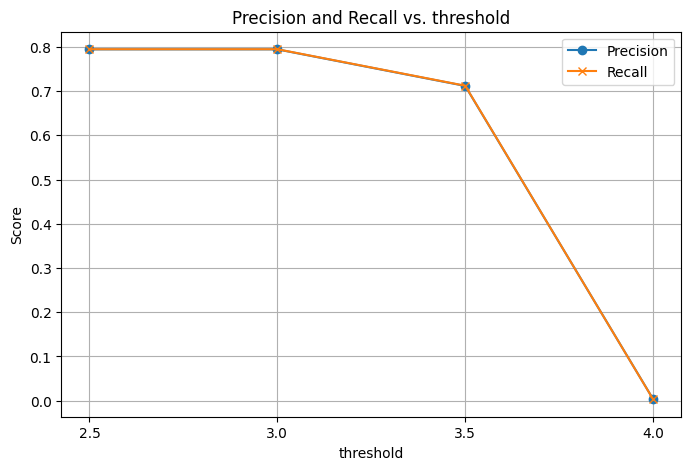

[0.7943190798138555, 0.7943190798138555, 0.7116515936429888, 0.003512160856967249]
[0.7946702958995522, 0.7946702958995522, 0.7121345157608219, 0.0031828957766265693]


In [ ]:
# Calculate Precision and Recall for different k values

ts = [2.5, 3, 3.5, 4]
precision_scores_means = []
recall_scores_means = []


for t in ts:
    precisions_means, recalls_means = precision_recall_at_k(predictions_means, k, threshold=t)
    avg_precision_means = sum(prec for prec in precisions_means.values()) / len(precisions_means)
    avg_recall_means = sum(rec for rec in recalls_means.values()) / len(recalls_means)
    precision_scores_means.append(avg_precision_means)
    recall_scores_means.append(avg_recall_means)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(ts, precision_scores_means, marker='o', linestyle='-', label='Precision')
plt.plot(ts, recall_scores_means, marker='x', linestyle='-', label='Recall')
plt.title('Precision and Recall vs. threshold')
plt.xlabel('threshold')
plt.ylabel('Score')
plt.xticks(ts)
plt.legend()
plt.grid(True)
plt.show()

print(precision_scores_means)
print(recall_scores_means)

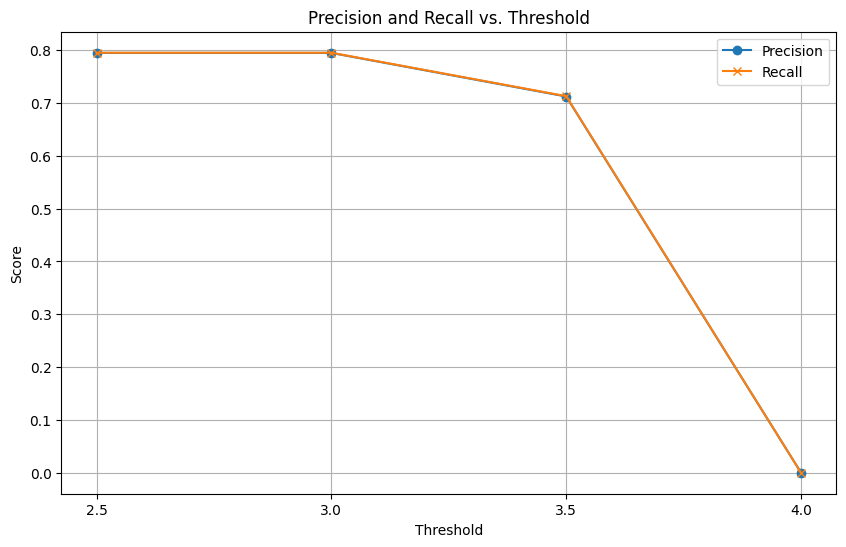

In [ ]:
# Calculate Precision and Recall for different threshold values
ts = [2.5, 3, 3.5, 4]
precision_scores = []
recall_scores = []


for t in ts:
    precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=t)
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    precision_scores.append(avg_precision)
    recall_scores.append(avg_recall)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(ts, precision_scores, marker='o', linestyle='-', label='Precision')
plt.plot(ts, recall_scores, marker='x', linestyle='-', label='Recall')
plt.title('Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(ts)
plt.legend()
plt.grid(True)
plt.show()

## **2.3 Item-based: Basic KNN**
Aka Content based. item-item tends to be stabler with sparse users.

In [ ]:
# Build the item-based KNN model
item_knn = KNNBasic(sim_options={'user_based': False, 'name':'pearson_baseline'})

# Train the model
item_knn.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# Make predictions on the testset
predictions_item = item_knn.test(testset)

# Evaluate the model using RMSE, MAE, Precision, Recall and AUC
item_knn_rmse = accuracy.rmse(predictions_item, verbose=False)
item_knn_mae = accuracy.mae(predictions_item, verbose=False)

print(f"Item-based KNN RMSE: {item_knn_rmse}")
print(f"Item-based KNN MAE: {item_knn_mae}")

# Calculate precision and recall at k
precisions_item, recalls_item = precision_recall_at_k(predictions_item, k=10, threshold=3.5)

# Precision and recall can then be averaged over all users
item_knn_precision = sum(prec for prec in precisions_item.values()) / len(precisions_item)
item_knn_recall = sum(rec for rec in recalls_item.values()) / len(recalls_item)

print("\nPrecision @ 10 (threshold = 3.5): ")
print(item_knn_precision)
print("\nRecall @ 10 (threshold = 3.5): ")
print(item_knn_recall)

Item-based KNN RMSE: 1.4935027265341292
Item-based KNN MAE: 1.2547800321504257

Precision @ 10 (threshold = 3.5): 
0.7122662217929581

Recall @ 10 (threshold = 3.5): 
0.7128808499429274


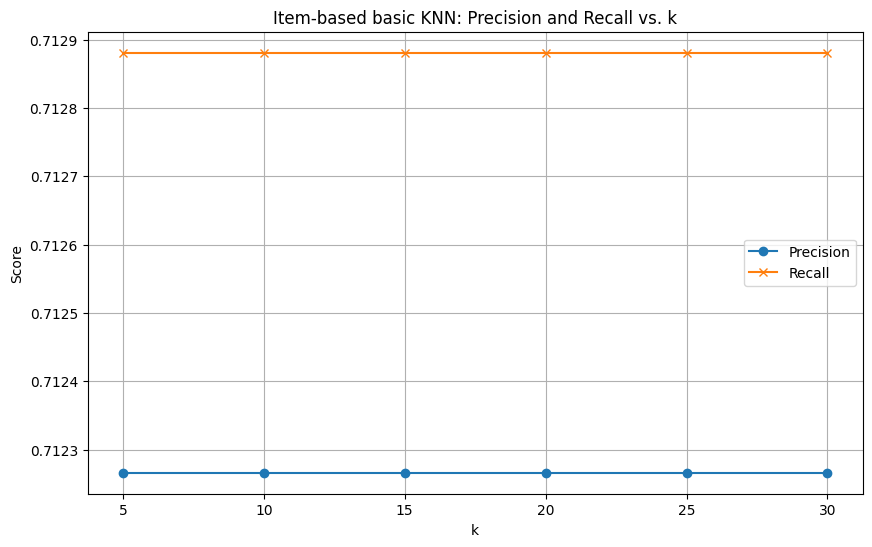

Precision scores for different k values (KNN items):
[0.7122662217929581, 0.7122662217929581, 0.7122662217929581, 0.7122662217929581, 0.7122662217929581, 0.7122662217929581]

Recall scores for different k values (KNN items):
[0.7128808499429274, 0.7128808499429274, 0.7128808499429274, 0.7128808499429274, 0.7128808499429274, 0.7128808499429274]


In [ ]:
# Calculate Precision and Recall for different k values for Item based Basic KNN
ks = [5, 10, 15, 20, 25, 30]
precision_scores_items_k = []
recall_scores_items_k = []


for k in ks:
    precisions_item_k, recalls_items_k = precision_recall_at_k(predictions_item, k=k, threshold=3.5)
    avg_precision_items_k = sum(prec for prec in precisions_item_k.values()) / len(precisions_item_k)
    avg_recall_items_k = sum(rec for rec in recalls_items_k.values()) / len(recalls_items_k)
    precision_scores_items_k.append(avg_precision_items_k)
    recall_scores_items_k.append(avg_recall_items_k)

# Plot the results for KNN with items
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_scores_items_k, marker='o', linestyle='-', label='Precision')
plt.plot(ks, recall_scores_items_k, marker='x', linestyle='-', label='Recall')
plt.title('Item-based basic KNN: Precision and Recall vs. k')
plt.xlabel('k')
plt.ylabel('Score')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

print("Precision scores for different k values (KNN items):")
print(precision_scores_items_k)
print("\nRecall scores for different k values (KNN items):")
print(recall_scores_items_k)

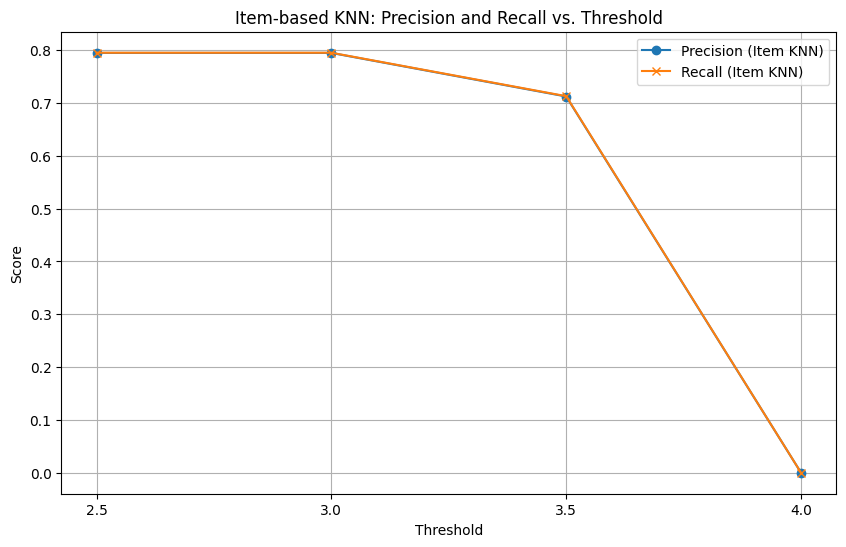

Precision scores for different threshold values (Item KNN):
[0.7947580999209763, 0.7947580999209763, 0.7122662217929581, 0.0]

Recall scores for different threshold values (Item KNN):
[0.7951532180173851, 0.7951532180173851, 0.7128808499429274, 0.0]


In [ ]:
# Calculate Precision and Recall for different threshold values for Item based Basic KNN
ts = [2.5, 3, 3.5, 4]
precision_scores_items_t = []
recall_scores_items_t = []

for t in ts:
    precisions_item_t, recalls_items_t = precision_recall_at_k(predictions_item, k=5, threshold=t)
    avg_precision_items_t = sum(prec for prec in precisions_item_t.values()) / len(precisions_item_t)
    avg_recall_items_t = sum(rec for rec in recalls_items_t.values()) / len(recalls_items_t)
    precision_scores_items_t.append(avg_precision_items_t)
    recall_scores_items_t.append(avg_recall_items_t)

# Plot the results for KNN with items
plt.figure(figsize=(10, 6))
plt.plot(ts, precision_scores_items_t, marker='o', linestyle='-', label='Precision (Item KNN)')
plt.plot(ts, recall_scores_items_t, marker='x', linestyle='-', label='Recall (Item KNN)')
plt.title('Item-based KNN: Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(ts)
plt.legend()
plt.grid(True)
plt.show()

print("Precision scores for different threshold values (Item KNN):")
print(precision_scores_items_t)
print("\nRecall scores for different threshold values (Item KNN):")
print(recall_scores_items_t)

# **3 SVD**

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate

# Build the SVD model
svd = SVD()

# Train the model
svd.fit(trainset)

# Evaluate the model using cross-validation
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4564  1.4623  1.4900  1.4742  1.4874  1.4740  0.0133  
MAE (testset)     1.2195  1.2234  1.2403  1.2298  1.2327  1.2291  0.0072  
Fit time          0.72    0.69    0.71    1.05    1.06    0.85    0.17    
Test time         0.05    0.04    0.04    0.05    0.06    0.05    0.01    


{'test_rmse': array([1.45636731, 1.46226114, 1.48999347, 1.4741854 , 1.48736696]),
 'test_mae': array([1.21949064, 1.22342882, 1.24025384, 1.22976339, 1.2327143 ]),
 'fit_time': (0.7181529998779297,
  0.690493106842041,
  0.7072780132293701,
  1.053980827331543,
  1.0590183734893799),
 'test_time': (0.04890012741088867,
  0.04481005668640137,
  0.03862953186035156,
  0.04761004447937012,
  0.05560421943664551)}

In [ ]:
# Make predictions on the testset
predictions_svd = svd.test(testset)

# Evaluate the model using RMSE, MAE, Precision, Recall
svd_rmse = accuracy.rmse(predictions_svd, verbose=False)
svd_mae = accuracy.mae(predictions_svd, verbose=False)

# Calculate precision and recall at k
precisions_svd, recalls_svd = precision_recall_at_k(predictions_svd, k=10, threshold=3.5)

# Precision and recall can then be averaged over all users
svd_precision = sum(prec for prec in precisions_svd.values()) / len(precisions_svd)
svd_recall = sum(rec for rec in recalls_svd.values()) / len(recalls_svd)

print(f"\nSVD RMSE: {svd_rmse}")
print(f"SVD MAE: {svd_mae}")

print("Precision @ 10 (threshold = 3.5): ")
print(svd_precision)
print("\nRecall @ 10 (threshold = 3.5): ")
print(svd_recall)



SVD RMSE: 1.1043590335664095
SVD MAE: 0.9038869362501589
Precision @ 10 (threshold = 3.5): 
0.7094125910966722

Recall @ 10 (threshold = 3.5): 
0.7097199051716568


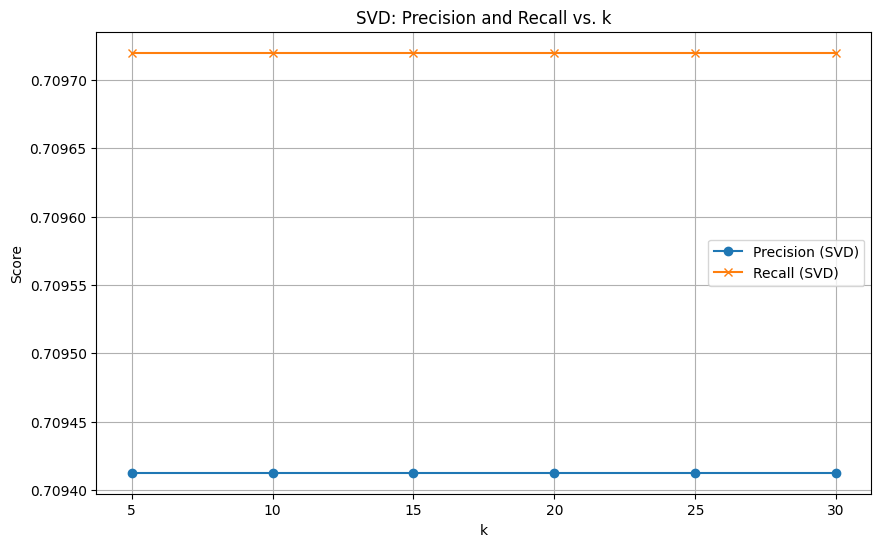

Precision scores for different k values (SVD):
[0.7094125910966722, 0.7094125910966722, 0.7094125910966722, 0.7094125910966722, 0.7094125910966722, 0.7094125910966722]

Recall scores for different k values (SVD):
[0.7097199051716568, 0.7097199051716568, 0.7097199051716568, 0.7097199051716568, 0.7097199051716568, 0.7097199051716568]


In [ ]:
# Calculate Precision and Recall for different k values for SVD
ks = [5, 10, 15, 20, 25, 30]
precision_scores_svd_k = []
recall_scores_svd_k = []

for k in ks:
    precisions_svd_k, recalls_svd_k = precision_recall_at_k(predictions_svd, k=k, threshold=3.5)
    avg_precision_svd_k = sum(prec for prec in precisions_svd_k.values()) / len(precisions_svd_k)
    avg_recall_svd_k = sum(rec for rec in recalls_svd_k.values()) / len(recalls_svd_k)
    precision_scores_svd_k.append(avg_precision_svd_k)
    recall_scores_svd_k.append(avg_recall_svd_k)

# Plot the results for SVD
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_scores_svd_k, marker='o', linestyle='-', label='Precision (SVD)')
plt.plot(ks, recall_scores_svd_k, marker='x', linestyle='-', label='Recall (SVD)')
plt.title('SVD: Precision and Recall vs. k')
plt.xlabel('k')
plt.ylabel('Score')
plt.xticks(ks)
plt.legend()
plt.grid(True)
plt.show()

print("Precision scores for different k values (SVD):")
print(precision_scores_svd_k)
print("\nRecall scores for different k values (SVD):")
print(recall_scores_svd_k)

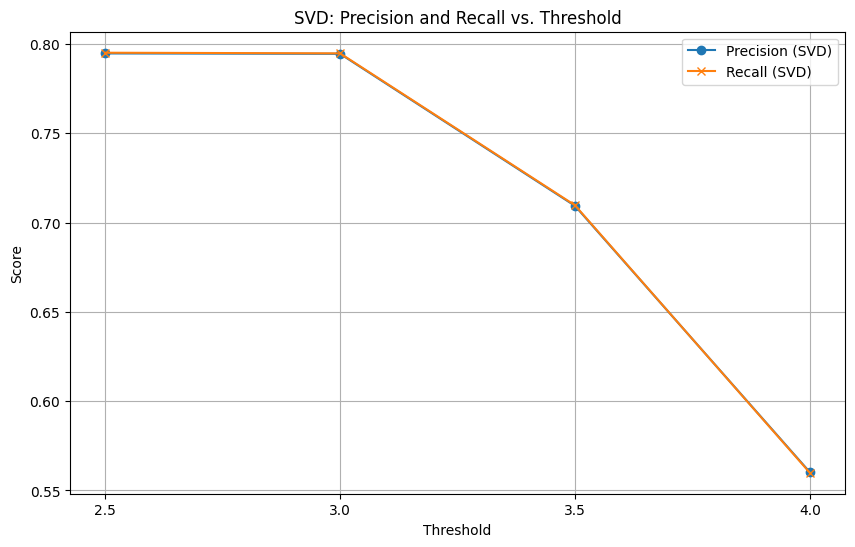

Precision scores for different threshold values (SVD):
[0.7947580999209763, 0.7945385898674159, 0.7094125910966722, 0.5602774607077005]

Recall scores for different threshold values (SVD):
[0.7951532180173851, 0.7948020019316885, 0.7097199051716568, 0.5599481956273598]


In [ ]:
# Calculate Precision and Recall for different threshold values for SVD
ts = [2.5, 3, 3.5, 4]
precision_scores_svd_t = []
recall_scores_svd_t = []

for t in ts:
    precisions_svd_t, recalls_svd_t = precision_recall_at_k(predictions_svd, k=5, threshold=t)
    avg_precision_svd_t = sum(prec for prec in precisions_svd_t.values()) / len(precisions_svd_t)
    avg_recall_svd_t = sum(rec for rec in recalls_svd_t.values()) / len(recalls_svd_t)
    precision_scores_svd_t.append(avg_precision_svd_t)
    recall_scores_svd_t.append(avg_recall_svd_t)

# Plot the results for SVD
plt.figure(figsize=(10, 6))
plt.plot(ts, precision_scores_svd_t, marker='o', linestyle='-', label='Precision (SVD)')
plt.plot(ts, recall_scores_svd_t, marker='x', linestyle='-', label='Recall (SVD)')
plt.title('SVD: Precision and Recall vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.xticks(ts)
plt.legend()
plt.grid(True)
plt.show()

print("Precision scores for different threshold values (SVD):")
print(precision_scores_svd_t)
print("\nRecall scores for different threshold values (SVD):")
print(recall_scores_svd_t)

# **4 Deep Learning**
Using Neural Collaborative Filtering, we implement a model using tensorflow.keras and evaluate how well the model does.

In [ ]:
# Define the model

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Input
from tensorflow.keras.models import Model

# Define the model
def build_ncf_model(num_users, num_items, embedding_size=50):
    # User and item input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    # Embedding layers
    user_embedding = Embedding(num_users, embedding_size)(user_input)
    item_embedding = Embedding(num_items, embedding_size)(item_input)

    # Flatten the embeddings
    user_embedding = Flatten()(user_embedding)
    item_embedding = Flatten()(item_embedding)

    # Concatenate user and item embeddings
    concatenated = Concatenate()([user_embedding, item_embedding])

    # Fully connected layers
    dense = Dense(128, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense)

    # Define the model
    model = Model(inputs=[user_input, item_input], outputs=output)
    return model

# Build the model
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()
model = build_ncf_model(num_users, num_items)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │  1,716,300 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │    976,850 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,706,207 (10.32 MB)

 Trainable params: 2,706,207 (10.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Prepare the training data for NCF model

trainset_list = []
# Iterate through all ratings in the trainset and append to a list
for uid, iid, rating in trainset.all_ratings():
    trainset_list.append({'user_id': trainset.to_raw_uid(uid), 'item_id': trainset.to_raw_iid(iid), 'rating': rating})
df_train = pd.DataFrame(trainset_list)

# Scale the ratings for train dataframe; fitting scaler to training data to prevent data leakage
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
df_train[['rating']] = scaler.fit_transform(df_train[['rating']])

# Map user and item IDs to integers for the NCF model
# Ensure user_id_map and item_id_map are created from the full dataset 'df'
# These maps should ideally be created once from the full dataset before splitting
user_id_map = {id: i for i, id in enumerate(df['user_id'].unique())}
item_id_map = {id: i for i, id in enumerate(df['item_id'].unique())}


df_train['user_id_mapped'] = df_train['user_id'].map(user_id_map)
df_train['item_id_mapped'] = df_train['item_id'].map(item_id_map)

# Drop rows with NaN values that might result from mapping (if train set contains unseen users/items - unlikely with build_full_trainset)
df_train.dropna(subset=['user_id_mapped', 'item_id_mapped'], inplace=True)

# Convert mapped IDs to integers
df_train['user_id_mapped'] = df_train['user_id_mapped'].astype(int)
df_train['item_id_mapped'] = df_train['item_id_mapped'].astype(int)


In [ ]:
# Prepare data for NCF training
# Keras models expect input as a list of arrays or a dictionary matching input layer names
user_inputs_train = df_train['user_id_mapped'].values
item_inputs_train = df_train['item_id_mapped'].values
ratings_train = df_train['rating'].values

# Now, fit the model
# You can specify epochs, batch_size, and validation_split or validation_data
# For example, fitting for 10 epochs with a batch size of 32
history = model.fit(
    [user_inputs_train, item_inputs_train],
    ratings_train,
    epochs=10,
    batch_size=32,
    # You can add validation data here if you have a separate validation set
    # validation_data=([user_inputs_val, item_inputs_val], ratings_val)
)

print("Model fitting complete.")

Epoch 1/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 0.1481 - root_mean_squared_error: 0.3846
Epoch 2/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.0461 - root_mean_squared_error: 0.2130
Epoch 3/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - loss: 0.0242 - root_mean_squared_error: 0.1547
Epoch 4/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.0086 - root_mean_squared_error: 0.0921
Epoch 5/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542
Epoch 6/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425
Epoch 7/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342
Epoch 8/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - loss: 8.8208e-04 - root_mean_squared_error: 0.0297
Epoch 9/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 7.8170e-04 - root_mean_squared_error: 0.0279
Epoch 10/10
727/727 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 5.

### Make Predictions with NCF Model

In [ ]:
# Prepare the test data for NCF model
# Convert Surprise testset (list of tuples) to a pandas DataFrame
testset_list = []
for uid, iid, rating in testset:
    testset_list.append({'user_id': uid, 'item_id': iid, 'rating': rating})
df_test = pd.DataFrame(testset_list)
print(df_test.head())

                        user_id     item_id  rating
0  AF7DQUMHMXQLSQ4XAPBVWRMWZICQ  B07V6F1TK2     5.0
1  AFUUSRA2XMB6CHRMPNGO2UC35QUQ  B01GS8J18E     1.0
2  AF56R4E2WEPQEAY6QMTWC73Z4CSA  B08617Z7KY     2.0
3  AHJVUUJUT4WULXNAPZ2WPKHIZHQQ  B08L5KN7X4     5.0
4  AGHQFIMZVOHV4DE63PIB624QS3DA  B072JG9WW8     5.0


In [ ]:
# Scale the ratings for test dataframe
df_test[['rating']] = scaler.transform(df_test[['rating']])
print(df_test.head())

                        user_id     item_id  rating
0  AF7DQUMHMXQLSQ4XAPBVWRMWZICQ  B07V6F1TK2    1.00
1  AFUUSRA2XMB6CHRMPNGO2UC35QUQ  B01GS8J18E    0.00
2  AF56R4E2WEPQEAY6QMTWC73Z4CSA  B08617Z7KY    0.25
3  AHJVUUJUT4WULXNAPZ2WPKHIZHQQ  B08L5KN7X4    1.00
4  AGHQFIMZVOHV4DE63PIB624QS3DA  B072JG9WW8    1.00


In [ ]:
# Map user and item IDs to integers for the NCF model
# Ensure user_id_map and item_id_map are created from the full dataset 'df'
user_id_map = {id: i for i, id in enumerate(df['user_id'].unique())}
item_id_map = {id: i for i, id in enumerate(df['item_id'].unique())}

df_test['user_id_mapped'] = df_test['user_id'].map(user_id_map)
df_test['item_id_mapped'] = df_test['item_id'].map(item_id_map)

# Drop rows with NaN values that might result from mapping (if test set contains unseen users/items)
df_test.dropna(subset=['user_id_mapped', 'item_id_mapped'], inplace=True)

# Convert mapped IDs to integers
df_test['user_id_mapped'] = df_test['user_id_mapped'].astype(int)
df_test['item_id_mapped'] = df_test['item_id_mapped'].astype(int)

# Prepare data for NCF prediction as NumPy arrays and reshape
user_inputs_test = df_test['user_id_mapped'].values.reshape(-1, 1)
item_inputs_test = df_test['item_id_mapped'].values.reshape(-1, 1)


# Make predictions
ncf_predictions = model.predict([user_inputs_test, item_inputs_test])

# Add predictions to df_test
df_test['ncf_predictions'] = ncf_predictions.flatten()

# Display head of df_test with predictions
print("DataFrame with NCF predictions:")
display(df_test.head())

358/358 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
DataFrame with NCF predictions:


,user_id,item_id,rating,user_id_mapped,item_id_mapped,ncf_predictions
0,AF7DQUMHMXQLSQ4XAPBVWRMWZICQ,B07V6F1TK2,1.00,25319,1208,0.625130
1,AFUUSRA2XMB6CHRMPNGO2UC35QUQ,B01GS8J18E,0.00,4235,3536,0.736290
2,AF56R4E2WEPQEAY6QMTWC73Z4CSA,B08617Z7KY,0.25,5489,4434,0.679017
3,AHJVUUJUT4WULXNAPZ2WPKHIZHQQ,B08L5KN7X4,1.00,16428,68,0.659987
4,AGHQFIMZVOHV4DE63PIB624QS3DA,B072JG9WW8,1.00,16089,9720,0.709923


### Evaluate NCF Model

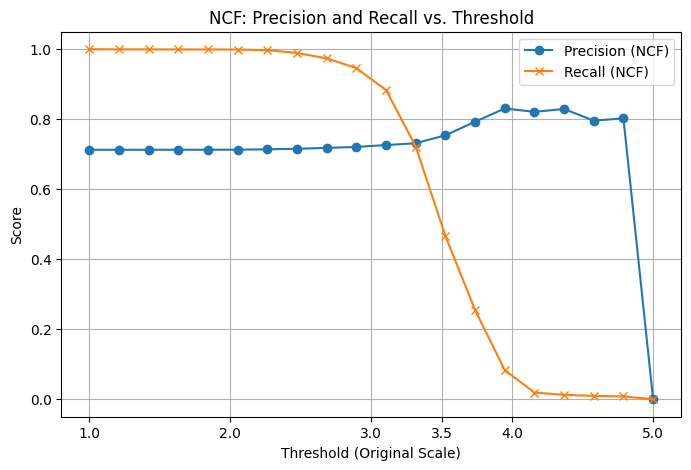

Precision scores for different threshold values (NCF):
[0.712776176753122, 0.7126758102559623, 0.7127380744364844, 0.7127752534078994, 0.7127501529319235, 0.7129491999650258, 0.7140601701605123, 0.7155516171909615, 0.7180923132508356, 0.7208477266361685, 0.7261736852710055, 0.7314377948845294, 0.7541146143168749, 0.7929061784897025, 0.8306748466257668, 0.8210526315789474, 0.8292682926829268, 0.7959183673469388, 0.8024691358024691, 0.0]

Recall scores for different threshold values (NCF):
[1.0, 0.9995099240382259, 0.9995099240382259, 0.9993874050477825, 0.9992648860573389, 0.9990198480764518, 0.9974271012006861, 0.9893408478314138, 0.974025974025974, 0.9459691252144082, 0.8831168831168831, 0.7217593727027689, 0.4659397206567018, 0.25471698113207547, 0.0829453565302622, 0.019112962509188924, 0.012496937025238911, 0.009556481254594462, 0.007963734378828718, 0.0]


In [ ]:
from sklearn.metrics import precision_score, recall_score # Import necessary metrics
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Calculate Precision and Recall for different threshold values for NCF
ts = np.linspace(0, 1, 20) # Create a range of scaled thresholds from 0 to 1
precision_scores_ncf_t = []
recall_scores_ncf_t = []

# Inverse transform the threshold for printing purposes
original_ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()


for t_scaled in ts:
    # Apply the scaled threshold to the scaled predictions
    df_test['ncf_predictions_binary'] = (df_test['ncf_predictions'] >= t_scaled).astype(int)

    # Calculate precision and recall using the original binary ratings and the new binary predictions
    original_threshold = 3.5
    df_test['rating_binary_at_t'] = ((df_test['rating'] * (scaler.data_range_[0])) + scaler.data_min_[0] >= original_threshold).astype(int)


    precision = precision_score(df_test['rating_binary_at_t'], df_test['ncf_predictions_binary'], zero_division=0)
    recall = recall_score(df_test['rating_binary_at_t'], df_test['ncf_predictions_binary'], zero_division=0)

    precision_scores_ncf_t.append(precision)
    recall_scores_ncf_t.append(recall)

# Plot the results for NCF
plt.figure(figsize=(8, 5))
plt.plot(original_ts, precision_scores_ncf_t, marker='o', linestyle='-', label='Precision (NCF)')
plt.plot(original_ts, recall_scores_ncf_t, marker='x', linestyle='-', label='Recall (NCF)')
plt.title('NCF: Precision and Recall vs. Threshold')
plt.xlabel('Threshold (Original Scale)')
plt.ylabel('Score')
# Set x-ticks to show some key original threshold values
plt.xticks([1.0, 2.0, 3.0, 3.5, 4.0, 5.0])
plt.legend()
plt.grid(True)
plt.show()

print("Precision scores for different threshold values (NCF):")
print(precision_scores_ncf_t)
print("\nRecall scores for different threshold values (NCF):")
print(recall_scores_ncf_t)

The precision and recall lines intersect. Based on the business goal (e.g., minimizing false positives or minimizing false negatives), a threshold that provides the best balance for a specific application can be chosen. For instance, if missing a positive interaction is more costly than making a false positive prediction, choose a lower threshold to prioritize recall. Conversely, if false positives are very undesirable, choose a higher threshold to prioritize precision.

This plot is a crucial tool for understanding the performance of my classification model and selecting an appropriate operating point (threshold) based on my business needs. As this is a Amazon recommendation system, missing a positive interaction is more costly than false positives being recommended. Hence, I select threshold = 3.5.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
import numpy as np


# Calculate RMSE and MAE
ncf_rmse = np.sqrt(mean_squared_error(df_test['rating'], df_test['ncf_predictions']))
ncf_mae = mean_absolute_error(df_test['rating'], df_test['ncf_predictions'])

# For Precision, Recall, and F1, convert predictions and true ratings to binary using a threshold.
# Use the scaled predictions for the thresholding
original_threshold = 3.5
threshold_scaled = scaler.transform([[original_threshold]])[0][0] # Scale the original threshold
print(f'Scaled Threshold is: {threshold_scaled}')
df_test['rating_binary'] = (df_test['rating'] >= threshold_scaled).astype(int)
df_test['ncf_predictions_binary'] = (df_test['ncf_predictions'] >= threshold_scaled).astype(int)


# Calculate Precision, Recall
ncf_precision = precision_score(df_test['rating_binary'], df_test['ncf_predictions_binary'], zero_division=0)
ncf_recall = recall_score(df_test['rating_binary'], df_test['ncf_predictions_binary'], zero_division=0)

print(f"NCF RMSE (scaled): {ncf_rmse}")
print(f"NCF MAE (scaled): {ncf_mae}")
print(f"NCF Precision (threshold={original_threshold}): {ncf_precision}")
print(f"NCF Recall (threshold={original_threshold}): {ncf_recall}")

Scaled Threshold is: 0.625
NCF RMSE (scaled): 0.39376337997712807
NCF MAE (scaled): 0.35833347520308945
NCF Precision (threshold=3.5): 0.7468727005150846
NCF Recall (threshold=3.5): 0.4974271012006861


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Comparison And Conclusion

## Comparison Table


In [ ]:
# Calculate RMSE and MAE for NCF
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np # Ensure numpy is imported if not already

ncf_rmse = np.sqrt(mean_squared_error(df_test['rating'], df_test['ncf_predictions']))
ncf_mae = mean_absolute_error(df_test['rating'], df_test['ncf_predictions'])

# Create a dictionary to store the metrics
comparison_data = {
    'Metric': ['RMSE', 'MAE', 'Precision', 'Recall'],
    'User KNN': [user_knn_rmse, user_knn_mae, user_knn_precision, user_knn_recall],
    'User KNN with Means': [user_knn_means_rmse, user_knn_means_mae, user_knn_means_precision, user_knn_means_recall],
    'Item KNN': [item_knn_rmse, item_knn_mae, item_knn_precision, item_knn_recall],
    'SVD': [svd_rmse, svd_mae, svd_precision, svd_recall],
    'NCF': [ncf_rmse, ncf_mae, ncf_precision, ncf_recall]
}

# Create a pandas DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the DataFrame
print('Recommendation Models Comparison\n')
display(comparison_df)

Recommendation Models Comparison



,Metric,User KNN,User KNN with Means,Item KNN,SVD,NCF
0,RMSE,1.493503,1.495446,1.493503,1.104359,0.393763
1,MAE,1.254780,1.254344,1.254780,0.903887,0.358333
2,Precision,0.712266,0.711652,0.712266,0.709413,0.746873
3,Recall,0.712881,0.712135,0.712881,0.709720,0.497427


## Graphical Comparison

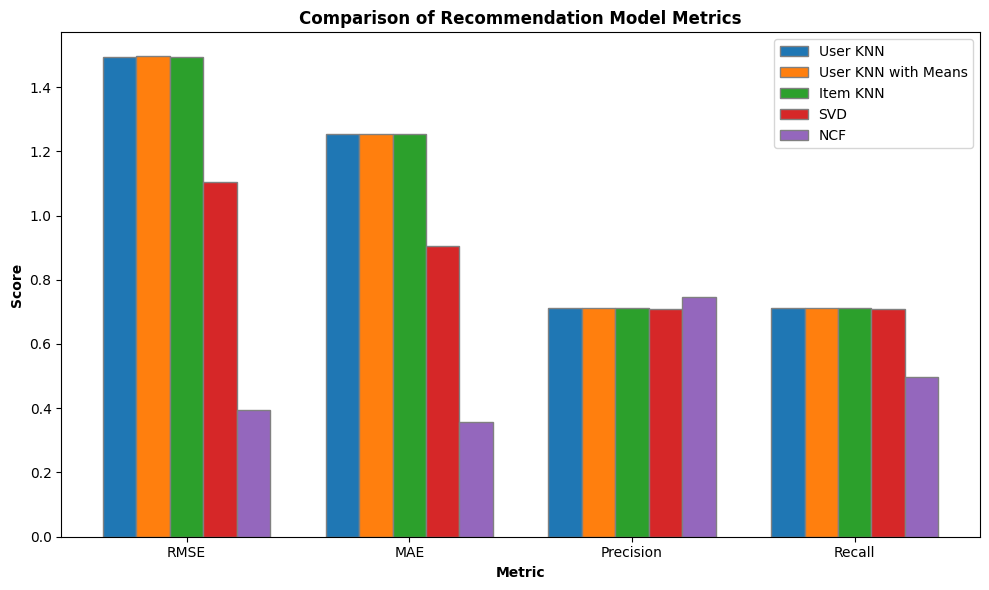

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported


comparison_df = pd.DataFrame(comparison_data)

# Reshape the DataFrame for plotting
comparison_melted = comparison_df.melt(
    id_vars='Metric',
    var_name='Model',
    value_name='Score'
)

# Drop rows with NaN values in the 'Score' column to avoid plotting issues
comparison_melted.dropna(subset=['Score'], inplace=True)

# Get the list of models and metrics
models = comparison_melted['Model'].unique()
metrics = comparison_melted['Metric'].unique()

# Set the bar width
bar_width = 0.15

# Set the positions of the bars on the x-axis
r = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

# Plot bars for each model
for i, model in enumerate(models):
    model_scores = comparison_melted[comparison_melted['Model'] == model]['Score'].values
    # Ensure the length of model_scores matches the number of metrics after dropping NaNs
    # Create a mapping from metric to score for the current model
    score_map = comparison_melted[comparison_melted['Model'] == model].set_index('Metric')['Score']
    aligned_scores = [score_map.get(metric, 0) for metric in metrics] # Use 0 or NaN for missing values


    plt.bar(r + i * bar_width, aligned_scores, width=bar_width, edgecolor='grey', label=model)

# Add xticks on the middle of the grouped bars
plt.xticks([pos + bar_width * (len(models) - 1) / 2 for pos in r], metrics)

# Add labels and title
plt.xlabel('Metric', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.title('Comparison of Recommendation Model Metrics', fontweight='bold')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

High precision, low recall means a model is very accurate when it makes a prediction, but it misses many of the actual positive cases. This is because the model is very conservative and only makes a prediction when it is highly confident, resulting in a small number of correct predictions (high precision) but failing to identify most of the true positives (low recall).
Why this happens
This happens when a model is set to be very "picky" and only flags something as a positive when it has very high confidence.
This is a result of a high classification threshold, which requires a very strong signal to make a positive prediction.
It is a trade-off: increasing the threshold to improve precision leads to missing more true positives, which lowers recall.
When high precision, low recall is useful
When the cost of a false positive is very high.
Example: A system that automatically bans toxic users from an online forum. It is better to let some toxic users go (false negatives) than to incorrectly ban an innocent user (false positive



---


# HyperParameter Tuning
Some experimentation

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'embedding_size': [32, 64, 128],
    'epochs': [5, 10, 15],
    'batch_size': [16, 32, 64]
    # You could also tune the number and size of dense layers, e.g.:
    # 'dense_layers': [[128], [128, 64], [256, 128]]
}

print("Hyperparameter grid defined:")
print(param_grid)

Hyperparameter grid defined:
{'embedding_size': [32, 64, 128], 'epochs': [5, 10, 15], 'batch_size': [16, 32, 64]}


In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
import numpy as np
import itertools

# Define the NCF model building function
def build_ncf_model(num_users, num_items, embedding_size=50):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    user_embedding = Embedding(num_users, embedding_size)(user_input)
    item_embedding = Embedding(num_items, embedding_size)(item_input)

    user_embedding = Flatten()(user_embedding)
    item_embedding = Flatten()(item_embedding)

    concatenated = Concatenate()([user_embedding, item_embedding])

    dense = Dense(128, activation='relu')(concatenated)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Prepare data: map user and item IDs to integers and scale ratings
user_id_map = {id: i for i, id in enumerate(df['user_id'].unique())}
item_id_map = {id: i for i, id in enumerate(df['item_id'].unique())}

df_mapped = df.copy()
df_mapped['user_id_mapped'] = df_mapped['user_id'].map(user_id_map)
df_mapped['item_id_mapped'] = df_mapped['item_id'].map(item_id_map)
df_mapped.dropna(subset=['user_id_mapped', 'item_id_mapped'], inplace=True)
df_mapped['user_id_mapped'] = df_mapped['user_id_mapped'].astype(int)
df_mapped['item_id_mapped'] = df_mapped['item_id_mapped'].astype(int)

X = df_mapped[['user_id_mapped', 'item_id_mapped']].values
y = df_mapped['rating'].values

num_users = df_mapped['user_id_mapped'].max() + 1
num_items = df_mapped['item_id_mapped'].max() + 1


# Define the hyperparameter grid
param_grid = {
    'embedding_size': [32, 64],
    'epochs': [5, 10],
    'batch_size': [16, 32]
}

# Manual Cross-Validation
n_splits = 3 # Reduced number of splits for faster execution
kf = KFold(n_splits=n_splits, shuffle=True, random_state=9)

results = []

# Iterate over all hyperparameter combinations
for embedding_size, epochs, batch_size in itertools.product(
    param_grid['embedding_size'],
    param_grid['epochs'],
    param_grid['batch_size']
):
    fold_rmse_scores = []
    fold_mae_scores = []
    fold_precision_scores = []
    fold_recall_scores = []

    print(f"Testing params: embedding_size={embedding_size}, epochs={epochs}, batch_size={batch_size}")

    # Perform cross-validation
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        # Split data for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Scale the target variable for the current fold
        scaler = MinMaxScaler()
        y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
        y_test_scaled = scaler.transform(y_test.reshape(-1, 1))


        # Build and train the model for the current fold
        model = build_ncf_model(num_users, num_items, embedding_size=embedding_size)
        model.fit(
            [X_train[:, 0], X_train[:, 1]], # Pass user and item IDs as separate inputs
            y_train_scaled,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0 # Set verbose to 0 to reduce output
        )

        # Make predictions on the test set for the current fold
        predictions_scaled = model.predict([X_test[:, 0], X_test[:, 1]], verbose=0)

        # Evaluate the model for the current fold
        rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions_scaled))
        mae = mean_absolute_error(y_test_scaled, predictions_scaled)

        # For Precision and Recall, use a threshold on the scaled predictions
        threshold_scaled = scaler.transform([[3.5]])[0][0] # Scale the threshold
        y_test_binary = (y_test_scaled >= threshold_scaled).astype(int)
        predictions_binary = (predictions_scaled >= threshold_scaled).astype(int)

        precision = precision_score(y_test_binary, predictions_binary, zero_division=0)
        recall = recall_score(y_test_binary, predictions_binary, zero_division=0)


        fold_rmse_scores.append(rmse)
        fold_mae_scores.append(mae)
        fold_precision_scores.append(precision)
        fold_recall_scores.append(recall)

    # Store the average metrics for the hyperparameter combination
    results.append({
        'embedding_size': embedding_size,
        'epochs': epochs,
        'batch_size': batch_size,
        'mean_rmse': np.mean(fold_rmse_scores),
        'mean_mae': np.mean(fold_mae_scores),
        'mean_precision': np.mean(fold_precision_scores),
        'mean_recall': np.mean(fold_recall_scores)
    })

# Print results
print("\nHyperparameter Tuning Results:")
for result in results:
    print(result)

# Find the best hyperparameters based on a chosen metric (e.g., maximizing recall while keeping RMSE/MAE low)
# This part would require defining what "best" means in terms of balancing metrics.
# For now, let's print the results and leave the selection to the user based on their goal (improve recall).

Testing params: embedding_size=32, epochs=5, batch_size=16
Testing params: embedding_size=32, epochs=5, batch_size=32
Testing params: embedding_size=32, epochs=10, batch_size=16
Testing params: embedding_size=32, epochs=10, batch_size=32
Testing params: embedding_size=64, epochs=5, batch_size=16
Testing params: embedding_size=64, epochs=5, batch_size=32
Testing params: embedding_size=64, epochs=10, batch_size=16
Testing params: embedding_size=64, epochs=10, batch_size=32

Hyperparameter Tuning Results:
{'embedding_size': 32, 'epochs': 5, 'batch_size': 16, 'mean_rmse': 0.3919982354219367, 'mean_mae': 0.35585777785438105, 'mean_precision': 0.7540496547531439, 'mean_recall': 0.48987265988356704}
{'embedding_size': 32, 'epochs': 5, 'batch_size': 32, 'mean_rmse': 0.39011149573286447, 'mean_mae': 0.3504154536569606, 'mean_precision': 0.7487010032344877, 'mean_recall': 0.5469210029922614}
{'embedding_size': 32, 'epochs': 10, 'batch_size': 16, 'mean_rmse': 0.4000777105385125, 'mean_mae': 0.364